# Исследование активности пользователей Википедии

# Оглавление   
[1 Описание проекта](#description)   
- [1.1 Описание данных](#data)    

[2 Данные по голосованиям](#votes)    
- [2.1  Загрузка и подготовка данных](#preparing1)    
- [2.2  Изучение данных](#analysis_votes)    
- [2.3  Результаты выборов](#result_votes)   
- [2.4  Голоса по дням](#votes_in_time)   
- [2.5  Вывод по разделу](#conclusion1)

[3  Данные пользователей](#stats)    
- [3.1  Загрузка и подготовка данных](#preparing2)    
- [3.2  Изучение данных](#analysis_users)    
- [3.3  Динамика показателей](#parametrs_in_time)
- [3.4  Сегментация пользователей](#segments)    
- [3.5  Вывод по разделу](#conclusion2)

[4  Агрегация данных](#agregation)    
- [4.1  Параметры голосующих пользователей](#rfm_votes)    
- [4.2  Параметры кандидатов](#rfm_candidates)
- [4.3  Вывод по разделу](#conclusion3)

[5  Результаты исследования](#result)    

## Описание проекта <a id='description'></a>

В нашем распоряжении данные о пользовтаелях и выборах в Википедии.На основе этих данных мы проведём анализ активности пользователей, выявим их
предпочтения, сделаем сегментацию, выясним кто такой типичный пользователь.    

Цель проекта:    
- Изучить данные, привести их в пригодный для анализа формат.
- Обнаружить в них значимые инсайты.
- Исследовать голосующую аудиторию проекта.
- Разделить пользователей на сегменты и изучить данные подробнее в разрезе сегментов.

Исследование проведём в три этапа:
- Исследование данных о голосованиях
- Исследование данных о пользователях
- Исследование агрегированных данных

### Описание данных <a id='data'></a>

**stats** — информация о пользователях    
- Edits - Количество правок    
- Reverts - Количество отмен чужих правок    
- Log - Количество иных действий    
- Diff - Добавленное минус удалённое    
- Volume - Общий объём добавленного    
- Tot size - Накопленная сумма добавленного    
- Time - Время онлайн    
- Speed - Скорость (количество правок в единицу времени)    
- User - Ник пользователя    
- txt - Дата в текстовом формате    

**votes** — информация о голосовании
- voter - Голосующий    
- can_vote - Проходит по критериям    
- time - Время голоса    
- candidate - Кандидат, по которому голос    
- n - Номер выборов, с дробными частями - довыборы    
- vote - Голос, 1 - за, -1 - против    
- lt - Суток от начала текущих выборов    

## Данные по голосованиям <a id='votes'></a>

### Загрузка и подготовка данных <a id='preparing1'></a>

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import datetime as dt
import math

pd.options.mode.chained_assignment = None

Первыми загрузим данные о выборах

In [161]:
try:
    votes = pd.read_excel('/datasets/votes.xlsx')
except:
    votes = pd.read_excel('votes.xlsx')
    
pd.set_option('display.max_columns', None)

In [162]:
votes.head()

,voter,can_vote,time,candidate,n,vote,lt
0,Kalan,True,2008-11-23 00:32:00,EvgenyGenkin,7.0,1,0.022222
1,Kalan,True,2008-11-23 00:32:00,Solon,7.0,-1,0.022222
2,Altes,True,2008-11-23 00:34:00,Agent001,7.0,-1,0.023611
3,Altes,True,2008-11-23 00:34:00,Chronicler,7.0,1,0.023611
4,Altes,True,2008-11-23 00:34:00,EvgenyGenkin,7.0,1,0.023611


In [163]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79074 entries, 0 to 79073
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   voter      79074 non-null  object 
 1   can_vote   79074 non-null  bool   
 2   time       79074 non-null  object 
 3   candidate  79074 non-null  object 
 4   n          79074 non-null  float64
 5   vote       79074 non-null  int64  
 6   lt         79074 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 3.7+ MB


Таблица загрузилась корректно, в ней 79074 записей об отданных пользователями голосах. Типы данных соответствуют содержащейся информации, кроме столбца `time`, приведём его к формату datetime. 

In [164]:
votes['time'] = pd.to_datetime(votes['time'], format='%Y-%m-%d %H:%M')

Все данные в нужном формате, теперь проверим пропуски в значениях

In [165]:
votes.isna().sum()

voter        0
can_vote     0
time         0
candidate    0
n            0
vote         0
lt           0
dtype: int64

Пропуски отсутствуют, осталось проверить наличие дубликатов

In [166]:
votes.duplicated().sum()

0

Дубликатов в данных нет.

**Вывод:**    
Таблица загрузилась корректно, в ней 79074 записей об отданных пользователями голосах, что является достаточной выборкой для проведения исследования. Типы данных соответствуют содержащейся информации, кроме столбца time, который был приведён к формату datetime. Пропуски в значениях отсутствуют, дубликатов в данных нет.

### Изучение данных <a id='analysis_votes'></a>

Посмотрим общую информацию о проведенных выборах

In [167]:
print('В данных содержится информация о', votes['n'].nunique(), 'проведенных выборах')
votes['n'].unique()

В данных содержится информация о 44 проведенных выборах


array([ 7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  , 14.  , 15.  ,
       15.5 , 16.  , 17.  , 18.  , 18.5 , 19.  , 19.5 , 20.  , 21.  ,
       22.  , 22.5 , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 26.5 ,
       26.75, 27.  , 27.5 , 27.75, 28.  , 28.5 , 29.  , 29.5 , 30.  ,
       31.  , 32.  , 33.  , 34.  , 35.  , 35.5 , 36.  , 36.5 ])

In [168]:
print('Исследования начинается', votes['time'].dt.date.min(),
      ', последенее голование завершилось', votes['time'].dt.date.max(),
      ', длительность периода наблюдений', 
     round((votes['time'].dt.date.max() - votes['time'].dt.date.min()).days / 365.25, 1), 'лет.')

Исследования начинается 2008-11-23 , последенее голование завершилось 2023-08-30 , длительность периода наблюдений 14.8 лет.


In [169]:
print('За это время проголосовали', votes['voter'].nunique(), 'пользователя, количество кандидатов составило',
      votes['candidate'].nunique(), 'человек')

За это время проголосовали 1862 пользователя, количество кандидатов составило 227 человек


Посмотрим как распределяется количество голосов по времени

count    79074.000000
mean         2.020226
std          2.092180
min          0.000000
25%          0.407639
50%          0.981944
75%          3.216667
max          7.967361
Name: lt, dtype: float64

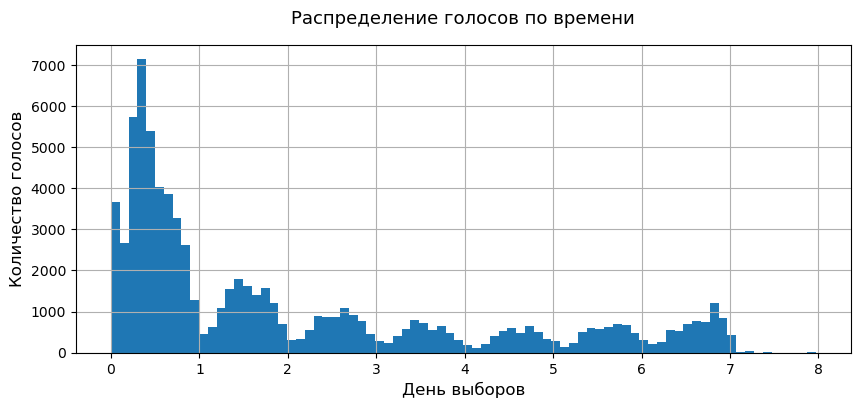

In [170]:
display(votes['lt'].describe())
votes['lt'].plot(kind='hist', grid=True, legend=False, bins=80, figsize=(10, 4))
plt.title('Распределение голосов по времени', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('День выборов', fontsize=12, color='black')
plt.ylabel('Количество голосов', fontsize=12, color='black')
plt.show()

Наибольшая активность голосования наблюдается в первый день, за этот день отдаётся половина голосов, но, несмотря на всплеск в начале голосования, среднее значение распределения не совпадает с медианным из-за сохранения активности пользователей в последующие дни.

Посмотрим как предпочитают голосовать пользователи: за кандидатов, или против

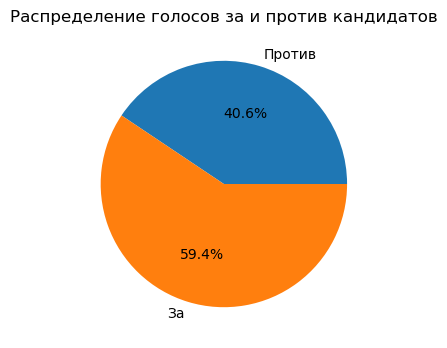

In [171]:
vote_type = votes.pivot_table(index='vote', values='voter', aggfunc='count')
vote_type['vote_percent'] = (vote_type['voter'] / vote_type['voter'].sum())
vote_type['kind'] = 0
vote_type.loc[vote_type.index == -1, 'kind'] = 'Против'
vote_type.loc[vote_type.index == 1, 'kind'] = 'За'
vote_type['vote_percent'].plot(kind='pie', legend=False, figsize=(4, 4), autopct='%.1f%%', labels=vote_type['kind'])
plt.title('Распределение голосов за и против кандидатов')
plt.ylabel('', fontsize=13, color='black')
plt.show()

Чаще пользователи голосуют за кандидатов, но голосов против набирается 40%

Теперь рассмотрим кандидатов. Для того чтобы понять сколько раз они принимали участие в выборах создадим столбец с уникальным именем кандидата для каждых выборов

In [172]:
votes['candidate_n'] = votes['candidate'] + '_' + votes['n'].astype('str')
votes.candidate_n = votes.candidate_n.str.replace('.', '_', regex=False)
votes.head()

,voter,can_vote,time,candidate,n,vote,lt,candidate_n
0,Kalan,True,2008-11-23 00:32:00,EvgenyGenkin,7.0,1,0.022222,EvgenyGenkin_7_0
1,Kalan,True,2008-11-23 00:32:00,Solon,7.0,-1,0.022222,Solon_7_0
2,Altes,True,2008-11-23 00:34:00,Agent001,7.0,-1,0.023611,Agent001_7_0
3,Altes,True,2008-11-23 00:34:00,Chronicler,7.0,1,0.023611,Chronicler_7_0
4,Altes,True,2008-11-23 00:34:00,EvgenyGenkin,7.0,1,0.023611,EvgenyGenkin_7_0


Уникальные имена присвоены, посмотрим, как часто кандидаты участвуют в выборах

,candidate_n
candidate,
Фил Вечеровский,14
Neolexx,12
Vyacheslav84,9
Arsenal.UC,9
A.Vajrapani,8
Biathlon,8
Sir Shurf,8
Vladimir Solovjev,8
Drbug,7


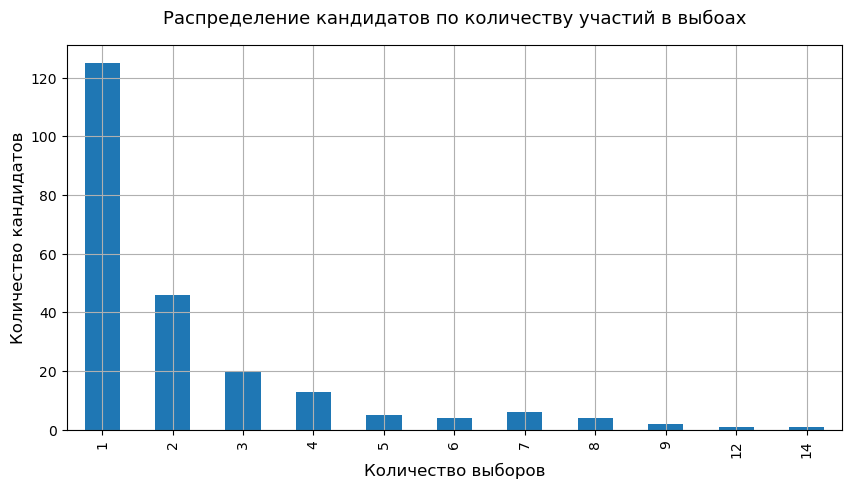

In [173]:
many_selection = votes.pivot_table(index='candidate', values='candidate_n', aggfunc='nunique')
display(many_selection.sort_values(by='candidate_n', ascending=False).head(10))

many = many_selection.groupby(by='candidate_n')['candidate_n'].count()
many.plot(kind='bar', grid=True, legend=False, figsize=(10, 5))
plt.title('Распределение кандидатов по количеству участий в выбоах', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Количество выборов', fontsize=12, color='black')
plt.ylabel('Количество кандидатов', fontsize=12, color='black')
plt.show()

Чаще всего кандидат принимает участие в одних или двух выборах, но встречаются кандидаты с большим количеством участий, вплоть до 14

**Вывод:**    
В данных содержится информация о 44 проведенных выборах за почти 15 лет с 2008-11-23 до 2023-08-30.
Наибольшая активность голосования наблюдается в день начала выборов, в этот день отдаётся половина голосов, но, несмотря на всплеск в начале голосования, среднее и медианное значение распределения не совпадают из-за сохранения активности пользователей в последующие дни. Чаще пользователи голосуют за кандидатов, но голосов противников набирается 40%.
Обычно кандидат принимает участие в одних или двух выборах, но встречаются кандидаты с большим количеством участий, вплоть до 14

### Результаты выборов <a id='votes_result'></a>

Посчитаем для кандидатов количество сторонников, противников и результаты выборов.    
В подсчёте результатов будем учитывать **только голоса пользователей, подходящих по параметрам** (столбец `can_vote` имеет значение **True**)

In [174]:
def cons_counter(row):
    if (row['vote'] == -1):
        return 1
    else:
        return 0
votes_true = votes.query('can_vote == True')
    
votes_true['cons'] = votes_true.apply(cons_counter, axis=1)
votes_result = votes_true.groupby('candidate_n').agg({'vote' : ['count', 'sum'], 'cons' : ['sum']})
votes_result.columns = ['count', 'sum', 'cons']
votes_result['pros'] = votes_result['count'] - votes_result['cons']
votes_result['result'] = votes_result['sum'] / votes_result['count']
votes_result.sort_values(by='result', ascending=False).head(10)

,count,sum,cons,pros,result
candidate_n,,,,,
Юрий Владимирович Л__30_0,160,144,8,152,0.900000
Сайга_31_0,165,145,10,155,0.878788
Rubin16_16_0,183,149,17,166,0.814208
Lesless_30_0,179,145,17,162,0.810056
D_bratchuk_18_0,206,166,20,186,0.805825
Vladimir Solovjev_10_0,216,174,21,195,0.805556
Yaroslav Blanter_8_0,251,201,25,226,0.800797
Vladimir Solovjev_12_0,266,212,27,239,0.796992
Draa kul_33_0,224,176,24,200,0.785714


Дважды в топ-10 не удалось попасть никому из кандидатов, посмотрим, как распределяются их сторонники и противники

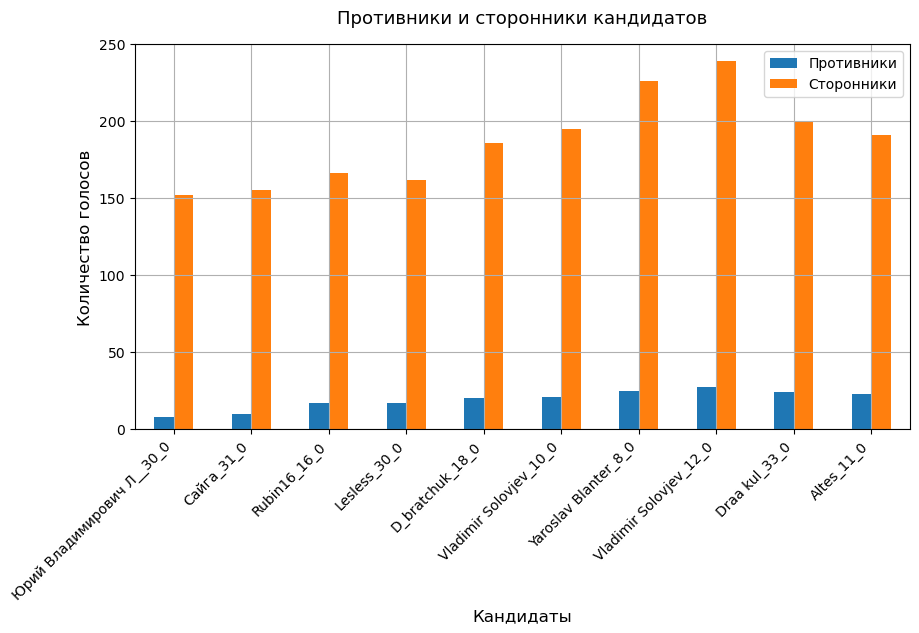

In [175]:
best_candidates_for_all_time = votes_result.query('result > 0.78')

best_candidates_for_all_time.sort_values(by='result', ascending=False).plot(y=['cons', 'pros'], kind='bar', \
        grid=True, legend=True, ylim=(0, 250), figsize=(10, 5))
plt.title('Противники и сторонники кандидатов', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Кандидаты', fontsize=12, color='black')
plt.ylabel('Количество голосов', fontsize=12, color='black')
plt.xticks(rotation=45, horizontalalignment='right')
plt.legend(['Противники', 'Сторонники']);
plt.show()

Топ-10 кандидатов по результатам выборов показывает, что порой получают лучший результат не те кандидаты, у кого больше сторонников, а те, у кого меньше противников.

Посмотрим как в целом распределяются результаты выборов

count    337.000000
mean       0.135808
std        0.440307
min       -0.911330
25%       -0.202454
50%        0.236111
75%        0.491329
max        0.900000
Name: result, dtype: float64

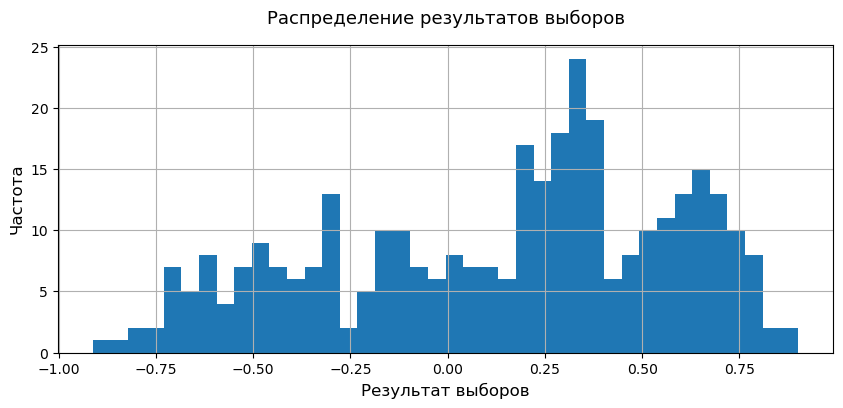

In [176]:
display(votes_result['result'].describe())
votes_result['result'].plot(kind='hist', grid=True, legend=False, bins=40, figsize=(10, 4))
plt.title('Распределение результатов выборов', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Результат выборов', fontsize=12, color='black')
plt.ylabel('Частота', fontsize=12, color='black')

plt.show()

Чаще всего кандидаты не преодолевают порог поддержки 50%, медианное значение по выборам 0.44, а среднее значение результата близко к нулю и составляет 0.13, из-за большого количества отрицательных результатов у кандидатов.

**Вывод:**    
Произвели расчёт количества сторонников, противников кандидатов и результатов выборов, в подсчёте результатов учитывались только голоса пользователей, подходящих по параметрам.    
Распределение сторонников и противников для кандидатов из топ-10 по результатам выборов показывает, что порой получают лучший результат не те кандидаты, у кого больше сторонников, а те, у кого меньше противников. Дважды в топ-10 не удалось попасть никому из кандидатов.    
Чаще всего кандидаты не преодолевают порог поддержки 50%, медианное значение по выборам 0.44, а среднее значение результата близко к нулю и составляет 0.13, из-за большого количества отрицательных результатов у кандидатов.


### Голоса по дням <a id='votes_in_time'></a>

Изучим распределени результатов по дням выборов, для этого сначала создадим столбец с номером дня от начала выборов

In [177]:
votes_true['vote_day_num'] = votes_true['lt'].agg(lambda x : math.ceil(x))
votes_true.head()

,voter,can_vote,time,candidate,n,vote,lt,candidate_n,cons,vote_day_num
0,Kalan,True,2008-11-23 00:32:00,EvgenyGenkin,7.0,1,0.022222,EvgenyGenkin_7_0,0,1
1,Kalan,True,2008-11-23 00:32:00,Solon,7.0,-1,0.022222,Solon_7_0,1,1
2,Altes,True,2008-11-23 00:34:00,Agent001,7.0,-1,0.023611,Agent001_7_0,1,1
3,Altes,True,2008-11-23 00:34:00,Chronicler,7.0,1,0.023611,Chronicler_7_0,0,1
4,Altes,True,2008-11-23 00:34:00,EvgenyGenkin,7.0,1,0.023611,EvgenyGenkin_7_0,0,1


На следующем этапе сгруппируем данные по кандидатам и дням голосования, чтобы получить количество голосов в день

In [178]:
votes_grouped = votes_true.groupby(['candidate_n', 'vote_day_num'], as_index=False).agg({'vote' : ['sum', 'count']})
votes_grouped.columns = ['candidate', 'voteday', 'votesum', 'votecount']
votes_grouped.head()

,candidate,voteday,votesum,votecount
0,A_Vajrapani_15_0,1,41,89
1,A_Vajrapani_15_0,2,12,28
2,A_Vajrapani_15_0,3,5,17
3,A_Vajrapani_15_0,4,8,8
4,A_Vajrapani_15_0,5,-1,13


Теперь посчитаем с накоплением голоса за день и результат.

In [179]:
votes_grouped['cumsum'] = 0
votes_grouped['cumvote'] = 0
votes_grouped.loc[0, 'cumsum'] = votes_grouped.loc[0, 'votesum']#56
votes_grouped.loc[0, 'cumvote'] = votes_grouped.loc[0, 'votecount']#70
for ind in range(1, len(votes_grouped)):
    if votes_grouped.loc[ind, 'candidate'] == votes_grouped.loc[(ind - 1), 'candidate']:
        votes_grouped.loc[ votes_grouped.index == ind, 'cumsum'] = (votes_grouped.loc[ind, 'votesum'] 
                                                                    + votes_grouped.loc[(ind - 1), 'cumsum'])
        votes_grouped.loc[ votes_grouped.index == ind, 'cumvote'] = (votes_grouped.loc[ind, 'votecount'] 
                                                                     + votes_grouped.loc[(ind - 1), 'cumvote'])
    else:
        votes_grouped.loc[votes_grouped.index == ind, 'cumsum'] = votes_grouped.loc[ind, 'votesum']
        votes_grouped.loc[votes_grouped.index == ind, 'cumvote'] = votes_grouped.loc[ind, 'votecount']

votes_grouped['day_result'] = votes_grouped['cumsum'] / votes_grouped['cumvote']
votes_grouped.head()

,candidate,voteday,votesum,votecount,cumsum,cumvote,day_result
0,A_Vajrapani_15_0,1,41,89,41,89,0.460674
1,A_Vajrapani_15_0,2,12,28,53,117,0.452991
2,A_Vajrapani_15_0,3,5,17,58,134,0.432836
3,A_Vajrapani_15_0,4,8,8,66,142,0.464789
4,A_Vajrapani_15_0,5,-1,13,65,155,0.419355


Рассмотрим динамику голосования за кандидатов из топ-10

In [180]:
votes_grouped_best = votes_grouped.query('candidate in @best_candidates_for_all_time.index')

fig = px.line(votes_grouped_best, # загружаем данные
              x='voteday', # указываем столбец с данными для оси X
              y='day_result', # указываем столбец с данными для оси Y
              color='candidate', # обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике
# оформляем график
fig.update_layout(title='Результаты по дням голосования с накоплением',
                   xaxis_title='День голосования',
                   yaxis_title='Результат')
fig.update_layout(title={'x':0.5, 'xanchor': 'center'})
fig.show()

Похоже победители определяют свои лидерские позиции уже в первый день, а задача остальных дней, удерживать и преумножать результат.

Теперь посмотрим как выглядит распределение по всем кандидатам

In [181]:
votes_heatmap = votes_grouped.pivot_table(index='candidate', columns='voteday', values='day_result')

fig = px.imshow(votes_heatmap)
fig.update_layout(title='Результаты по дням голосования с накоплением',
                   xaxis_title='День голосования',
                   yaxis_title='Кандидат')
fig.update_layout(title={'x':0.5, 'xanchor': 'center'})
fig.show()

На большой выборке картина сохраняется: чаще всего лидеры и аутсайдеры определяются в первый день голосования, изменения результатов в последующие дни - незначительное

**Вывод:**    
Близкий к итоговому результат голосования определяются уже в первый день, в дальнейшие дни результат меняется незначительно

### Вывод по разделу: <a id='conclusion1'></a> 
Данные о голосованиях загружены без ошибок, после приведения данных в столбце `time` к формату datetime, все данные сохранились в нужном формате, пропуски и дубликаты отсутствуют. Итоговая таблица содержит 79074 записей, что является достаточной выборкой для проведения исследования.    

В данных содержится информация о 44 проведенных выборах за период с 2008-11-23 до 2023-08-30.
Наибольшая активность голосования наблюдается в день начала выборов, и в начале третьего дня отдаётся половина голосов, но, несмотря на всплеск в начале голосования, среднее и медианное значение распределения совпадают из-за сохранения активности пользователей в последующие дни. Чаще пользователи голосуют за кандидатов, но голосов противников набирается 40%.
Обычно кандидат принимает участие в одних или двух выборах, но встречаются кандидаты с большим количеством участий, вплоть до 14.

Произвели расчёт количества сторонников, противников кандидатов и результатов выборов, в подсчёте результатов учитывались только голоса пользователей, подходящих по параметрам.
Распределение сторонников и противников для кандидатов из топ-10 по результатам выборов показывает, что порой получают лучший результат не те кандидаты, у кого больше сторонников, а те, у кого меньше противников. Дважды в топ-10 не удалось попасть никому из кандидатов.
Чаще всего кандидаты не преодолевают порог поддержки 50%, медианное значение по выборам 0.44, а среднее значение результата близко к нулю и составляет 0.13, из-за большого количества отрицательных результатов у кандидатов.    

Близкий к итоговому результат голосования определяются уже в первый день, в дальнейшие дни результат меняется незначительно

## Данные пользователей <a id='stats'></a>

### Загрузка и подготовка данных <a id='preparing2'></a>

На следующем этапе загрузим данные о пользователях

In [182]:
try:
    stats = pd.read_excel('/datasets/stats.xlsx')
except:
    stats = pd.read_excel('stats.xlsx')
    
pd.set_option('display.max_columns', None)

In [183]:
stats.head()

,Edits,Reverts,Log,Diff,Volume,Tot size,Time,Speed,User,txt
0,1589,NaN,1621.0,262 k,1.1 M,39 M,95 h,34/h,Altes,200708
1,1809,NaN,1328.0,395 k,2.8 M,42 M,129 h,24/h,Obersachse,200708
2,2734,NaN,NaN,16 k,15 k,19 M,105 h,26/h,Monegasque~ruwiki,200708
3,2611,NaN,6.0,278 k,350 k,43 M,135 h,19/h,User№101,200708
4,917,6.0,1416.0,154 k,1.2 M,26 M,98 h,24/h,Kalan,200708


Таблица загрузилась без ошибок. Cначала приведём названия столбцов к змеиному регистру и поменяем название столбца `txt` на `report_month`, поскольку в нём отображается месяц на который собраны данные.

In [184]:
stats.columns = stats.columns.str.lower().str.replace(' ', '_')
stats = stats.rename(columns={'txt': 'report_month'})
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28950 entries, 0 to 28949
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   edits         28950 non-null  int64  
 1   reverts       10157 non-null  float64
 2   log           28306 non-null  float64
 3   diff          28945 non-null  object 
 4   volume        28945 non-null  object 
 5   tot_size      28945 non-null  object 
 6   time          28950 non-null  object 
 7   speed         28950 non-null  object 
 8   user          28950 non-null  object 
 9   report_month  28950 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.2+ MB


Не все данные в столбцах соответствуют содержащейся в них информации и присутствуют пропуски, начнём с них

In [185]:
stats.isna().sum()

edits               0
reverts         18793
log               644
diff                5
volume              5
tot_size            5
time                0
speed               0
user                0
report_month        0
dtype: int64

Не у всех пользователей есть информация об отменах правок, прочей деятельности, и объёме загруженной информации, это объясняется разной направленностью работы пользователей с платформой, там где у них не зафиксирована активность при дальнейшей обработке запишем нулевые значения. Проверим наличие дубликатов

In [186]:
stats.duplicated().sum()

0

Дубликаты отсутствуют. Теперь приведём данные к нужным для расчётов и построениям графиков форматам, начнём с отчётного месяца

In [187]:
stats['report_month'] = pd.to_datetime(stats['report_month'], format='%Y%m')

Теперь разберёмся с объёмом загруженной пользователем информации, объёмом с накоплением и разницей загруженного и удалённого,
сначала посмотрим как выглядят значения в столбцах

In [188]:
stats['volume'].unique()

array(['1.1\xa0M', '2.8\xa0M', '15\xa0k', ..., '8.6\xa0k', '9\xa0M',
       '444'], dtype=object)

В значениях присутствует разделитель `\xa0` - это символ скрытого пробела, как правило появляющийся в данных, после обработки  файлов excel. Также присутствует идентификатор множителя, указывающий миллионы и тысячи. Приведём данные к числовому формату, измеряемому в тысячах единиц, для этого подготовим функцию `to_float`

In [189]:
def to_float(num):
    num = str(num)
    num = num.lower()
    modificator = 1
    num_array = num.split('\xa0')
    if len(num_array) > 1 and num_array[1] == 'k':
        result = float(num_array[0])
    if len(num_array) > 1 and num_array[1] == 'm':
        result = float(num_array[0]) * 1024
    if len(num_array) == 1:
        result = float(num_array[0]) / 1024
    return result

In [190]:
stats['volume'] = stats['volume'].apply(to_float)
stats['tot_size'] = stats['tot_size'].apply(to_float)
stats['diff'] = stats['diff'].apply(to_float)
stats = stats.rename(columns={'volume': 'volume_k', 'tot_size': 'tot_size_k', 'diff': 'diff_k'})
stats.sort_values(by='volume_k').head()

,edits,reverts,log,diff_k,volume_k,tot_size_k,time,speed,user,report_month
23424,3,NaN,2124.0,0.181641,0.222656,22.0,9 h 05,4/m,Icannotyet,2020-08-01
23586,3,1.0,2010.0,0.077148,0.262695,108.0,13 h 40,2/m,Icannotyet,2020-09-01
25942,14,9.0,805.0,-0.049805,0.413086,129.0,14 h 30,56/h,Sleepyxls,2021-12-01
28929,736,NaN,4.0,0.179688,0.433594,15360.0,26 h,28/h,Иван Додин,2023-08-01
22460,11,1.0,989.0,0.570312,0.582031,224.0,15 h 25,1/m,Yyrida,2020-01-01


Данные по объёму приведены к числовому формату, теперь приведём к числовому формату данные о количестве действий и общем времени на платформе, для чего используем функции `speed_to_float` и `time_to_float`

In [191]:
def time_to_float(str_time):
    time_array = str_time.split('\xa0')
    if len(time_array) < 3:
        return float(time_array[0])
    else:
        return (float(time_array[-1]) / 60) + float(time_array[0])
    
def speed_to_float(speed_str):
    speed_array = speed_str.split('/')
    if speed_array[1] == 'h':
        return float(speed_array[0])
    else:
        return float(speed_array[0]) * 60

In [192]:
stats['time'] = stats['time'].apply(time_to_float)
stats['speed'] = stats['speed'].apply(speed_to_float)
stats = stats.rename(columns={'time': 'time_h', 'speed': 'speed_h'})
stats.sort_values(by='speed_h', ascending=False).head()

,edits,reverts,log,diff_k,volume_k,tot_size_k,time_h,speed_h,user,report_month
27450,0,NaN,35797.0,NaN,NaN,NaN,1.583333,22620.0,Martin Urbanec (WMF),2022-11-01
27300,0,NaN,29490.0,NaN,NaN,NaN,1.666667,17700.0,Martin Urbanec (WMF),2022-10-01
28651,21,3.0,10998.0,7.0,7.8,281.0,2.416667,4560.0,TakingOver,2023-07-01
27150,6100,6091.0,NaN,-3686.4,3686.4,98304.0,1.416667,4320.0,Cyberpower678,2022-09-01
8949,979,NaN,NaN,4608.0,4403.2,4403.2,55.000000,1080.0,DaraBotochka,2012-07-01


**Вывод:**    
Таблица загрузилась без ошибок, названия столбцов приведены змеиному регистру и изменено название столбца txt на report_month, поскольку в нём отображается месяц на который собраны данные.
В данных присутствуют пропуски в информации об отменах правок, прочей деятельности, и объёме загруженной информации, объясняющиеся разной направленностью работы пользователей с платформой, там где у них не зафиксирована активность при агрегации запишем нулевые значения. Дубликаты отсутствуют.
Данные об отчётном месяце приведены к формату datetime. Данные в столбцах `diff`, `volume`, `tot_size` для расчётов и построения графиков приведены к числовому формату, значения в столбцах измеряются в тысячах, поэтому к названию столбца добавлен множитель "k". К числовому формату приведены данные о количестве действий и общем времени на платформе, значения в столбцах измеряются в часах, поэтому к названию столбца добавлен множитель "h".

### Изучение данных <a id='analysis_users'></a>

Общее количество записей в таблице

In [193]:
total_len = len(stats)
total_len

28950

Количество уникальных пользователей

In [194]:
stats['user'].nunique()

2541

Количество месяцев на которые получены срезы данных

In [195]:
stats['report_month'].nunique()

193

Временной интервал, на который получены данные

In [196]:
print('Период исследования с', stats['report_month'].dt.date.min(), 'по', stats['report_month'].dt.date.max())

Период исследования с 2007-08-01 по 2023-08-01


В данных присутствуют записи с подозрительно большой активность, проверим записи с количеством действий более 60 в минуту

In [197]:
stats.loc[stats['speed_h'] > 3600]

,edits,reverts,log,diff_k,volume_k,tot_size_k,time_h,speed_h,user,report_month
27150,6100,6091.0,NaN,-3686.4,3686.4,98304.0,1.416667,4320.0,Cyberpower678,2022-09-01
27300,0,NaN,29490.0,NaN,NaN,NaN,1.666667,17700.0,Martin Urbanec (WMF),2022-10-01
27450,0,NaN,35797.0,NaN,NaN,NaN,1.583333,22620.0,Martin Urbanec (WMF),2022-11-01
28651,21,3.0,10998.0,7.0,7.8,281.0,2.416667,4560.0,TakingOver,2023-07-01


Похоже что это боты, которые за считанные часы совершили тысячи действий, но, видимо платформа имеет хорошую защиту, и такие атаки носят единичный характер, не внося искажение в общую статистику

Посмотрим как распределяется объём загруженных данных

In [198]:
display(stats['volume_k'].describe())

count    28945.000000
mean       576.149546
std        798.030444
min          0.222656
25%        220.000000
50%        384.000000
75%        663.000000
max      49152.000000
Name: volume_k, dtype: float64

Среднее отличается от медианы, в данных присутствуют выбросы, отбросим аномальные значения в три раза больше третьего квартиля

count    27956.000000
mean       475.971348
std        371.687408
min          0.222656
25%        216.000000
50%        371.000000
75%        625.000000
max       1945.600000
Name: volume_k, dtype: float64

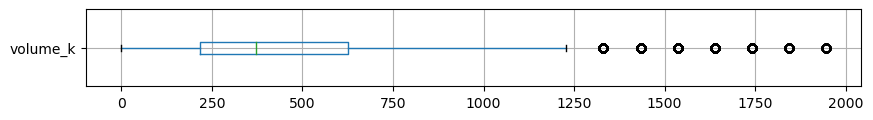

In [199]:
clean_data = stats.query('volume_k < 2000')
display(clean_data['volume_k'].describe())
clean_data.boxplot(column='volume_k', vert=False, figsize=(10, 1));

Отфильтрованная выборка составила 27956 записей, в среденем пользователи загружают 473 килобайта

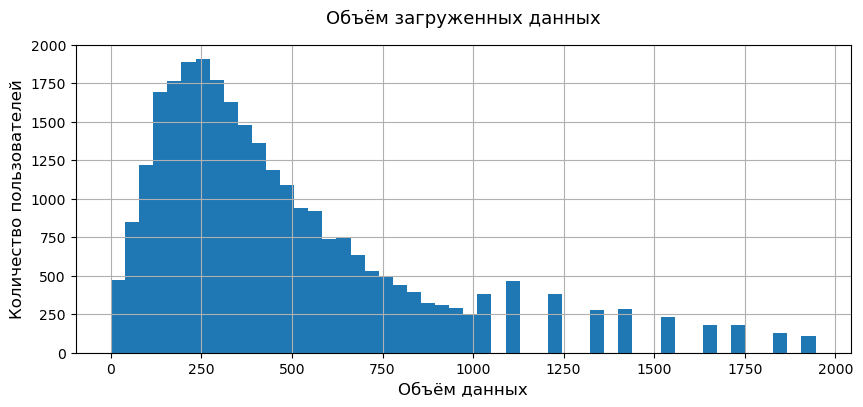

In [200]:
clean_data['volume_k'].plot(kind='hist', grid=True, legend=False, bins=50, figsize=(10, 4))
plt.title('Объём загруженных данных', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Объём данных', fontsize=12, color='black')
plt.ylabel('Количество пользователей', fontsize=12, color='black')
plt.show()

Чаще всего пользователи загружают около 250 килобайт, но не вся информация остаётся, посмотрим распределение разницы загруженных и удалённых данных

In [201]:
stats['diff_k'].describe()

count    28945.000000
mean       337.397569
std        682.327870
min      -5836.800000
25%         95.000000
50%        214.000000
75%        410.000000
max      51200.000000
Name: diff_k, dtype: float64

Среднее и медиана отличаются из-за выбросов, уберём аномальные значения в пять раз больше крайних квартилей

count    28366.000000
mean       293.872581
std        321.530489
min       -492.000000
25%         95.000000
50%        211.000000
75%        399.000000
max       1945.600000
Name: diff_k, dtype: float64

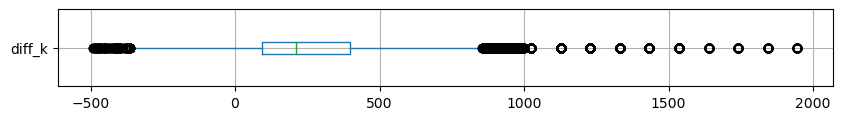

In [202]:
clean_diff = stats.query('diff_k < 2000 and diff_k > -500')
display(clean_diff['diff_k'].describe())
clean_diff.boxplot(column='diff_k', vert=False, figsize=(10, 1))
plt.show()

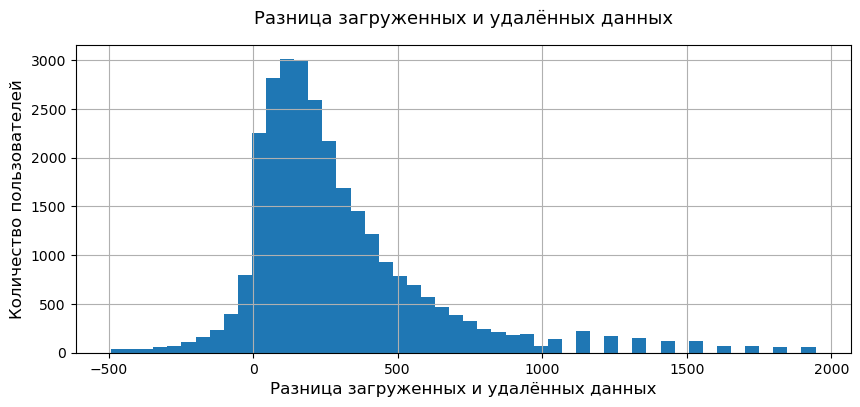

In [203]:
clean_diff['diff_k'].plot(kind='hist', grid=True, legend=False, bins=50, figsize=(10, 4))
plt.title('Разница загруженных и удалённых данных', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Разница загруженных и удалённых данных', fontsize=12, color='black')
plt.ylabel('Количество пользователей', fontsize=12, color='black')
plt.show()

Среднее значение для этого показателя ниже, чем у объёма загруженных даннных, из-за учета удалений, и составляет 292 килобайта вместо 473 что свидетельствует как о качественном отборе информации, так и надёжных изначальных данных.

На следующем этапе изучим распределение времени, проведенного на платформе

In [204]:
stats['time_h'].describe()

count    28950.000000
mean        62.030377
std         33.345291
min          1.333333
25%         41.000000
50%         54.000000
75%         74.000000
max        472.000000
Name: time_h, dtype: float64

Среднее значение отличается от медианного из-за пользователей проводящих на платформе аномально большое время, отфильтруем даннные, которые в два раза больше третьего квартиля

count    28241.000000
mean        58.871195
std         26.227940
min          1.333333
25%         41.000000
50%         53.000000
75%         72.000000
max        149.000000
Name: time_h, dtype: float64

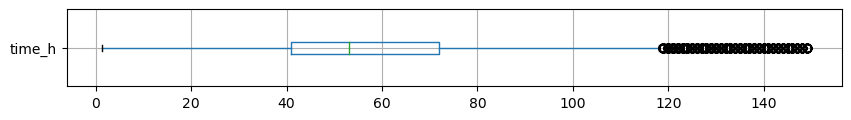

In [205]:
clean_time = stats.query('time_h < 150')
display(clean_time['time_h'].describe())
clean_time.boxplot(column='time_h', vert=False, figsize=(10, 1));

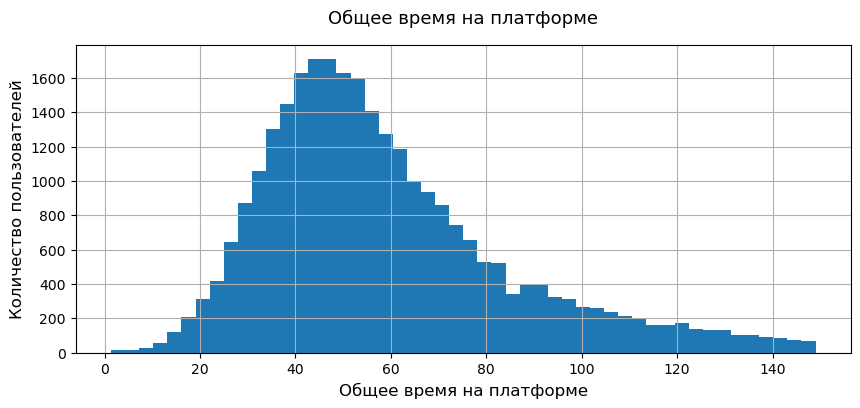

In [206]:
clean_time['time_h'].plot(kind='hist', grid=True, legend=False, bins=50, figsize=(10, 4))
plt.title('Общее время на платформе', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Общее время на платформе', fontsize=12, color='black')
plt.ylabel('Количество пользователей', fontsize=12, color='black')
plt.show()

Чаще всего пользователи проводят на платформе от 40 до 70 часов. Посмотрим как распределяется их активность

In [207]:
stats['speed_h'].describe()

count    28950.000000
mean        25.767703
std        173.828385
min          9.000000
25%         17.000000
50%         20.000000
75%         26.000000
max      22620.000000
Name: speed_h, dtype: float64

Наблюдаются выбросы в максимальном времени на платформе, отфильтруем их, взяв значения в 4 раз больше третьего квартиля

count    28752.000000
mean        22.931796
std          9.538423
min          9.000000
25%         17.000000
50%         20.000000
75%         26.000000
max         60.000000
Name: speed_h, dtype: float64

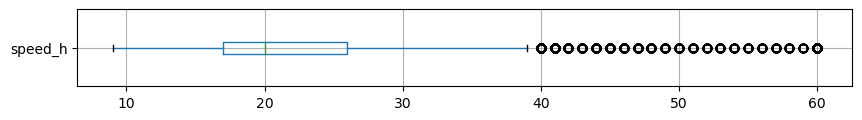

In [208]:
clean_speed = stats.query('speed_h < 100')
display(clean_speed['speed_h'].describe())
clean_speed.boxplot(column='speed_h', vert=False, figsize=(10, 1));

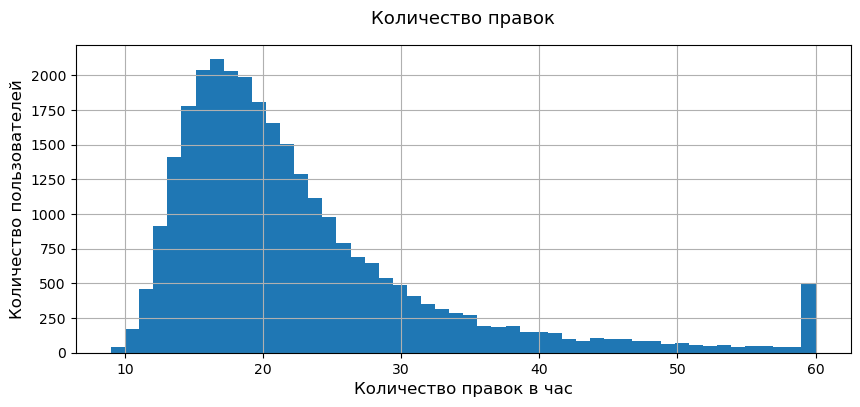

In [209]:
clean_speed['speed_h'].plot(kind='hist', grid=True, legend=False, bins=50, figsize=(10, 4))
plt.title('Количество правок', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Количество правок в час', fontsize=12, color='black')
plt.ylabel('Количество пользователей', fontsize=12, color='black')
plt.show()

Чаще всего пользователи совершают около 20 действий в час. Выброс в районе 60 правок в час связан с тем, что часто 

Проверим, есть ли зависимость объёма добавленной инормации от времени, проведённого на платформе 

Коэффициент корреляции времени на платформе и объёма добавленных данных: 0.43367817561415617


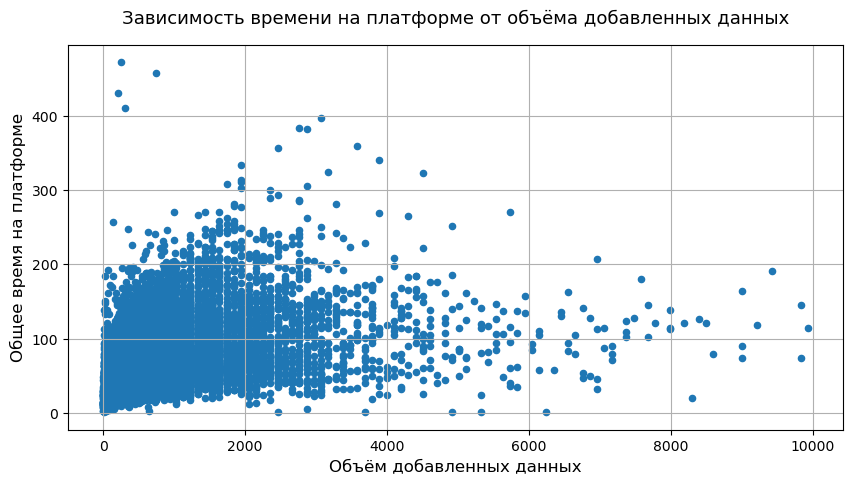

In [210]:
clean_data = stats.query('volume_k < 10000')
print('Коэффициент корреляции времени на платформе и объёма добавленных данных:', \
      clean_data['time_h'].corr(clean_data['volume_k']))
clean_data.plot(y='time_h', x='volume_k', kind='scatter', \
         figsize=(10, 5), sharex=False, grid=True)
plt.title('Зависимость времени на платформе от объёма добавленных данных', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Объём добавленных данных', fontsize=12, color='black')
plt.ylabel('Общее время на платформе', fontsize=12, color='black')
plt.show()

Корреляция незначительная, график показывает, что основная часть пользователей проводят на платформе не более 200 часов и добавляют не более 2 мегабайт данных

**Вывод:**    
Общее количество записей в таблице 28950. Данные получены за 193 месяца с 2007-08-01 по 2023-08-01, что является достаточной выборкой для проведения исследования. В данных присутствуют записи с подозрительно большой активностью (более 60 действий в минуту), похоже что это боты, которые за считанные часы совершили тысячи действий, но в выборке такие случаи носят единичный характер, не внося искажение в общую статистику, что свидетельствует о хороше защите платформы.    
Средний объём загружаемых пользователем данных составляет 473 килобайта. Чаще всего пользователи загружают около 250 килобайт, но не вся информация остаётся, с учетом удалений данных, в среднем итоговый объём составляет 292 килобайта вместо 473, что свидетельствует как о качественном отборе информации, так и надёжных изначальных данных.    
Обычно пользователи проводят на платформе от 40 до 70 часов и совершают около 20 действий в час.
Зависимость объёма добавленной инормации от времени, проведённого на платформе незначительная, коэффициент корреляции равен 0.4.
Основная часть пользователей проводит на платформе не более 200 часов и добавляют не более 2 мегабайт данных.

### Динамика показателей <a id='parametrs_in_time'></a>

Рассмотрим как изменялось количество правок активными пользователями по месяцам

Среднее количество правок в месяц 166262.82901554403


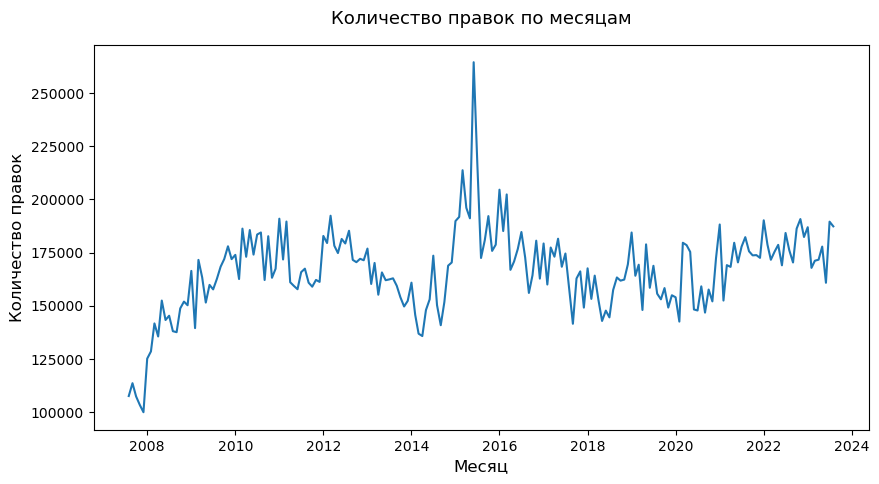

In [211]:
plt.figure(figsize=(10, 5))
edits_time = stats.pivot_table(index='report_month', values='edits', aggfunc=['sum'])
edits_time.reset_index(inplace=True)
edits_time.columns = ['month', 'edits']
print('Среднее количество правок в месяц', edits_time['edits'].mean())
sns.lineplot(x=edits_time['month'], y=edits_time['edits'])
plt.title('Количество правок по месяцам', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Месяц', fontsize=12, color='black')
plt.ylabel('Количество правок', fontsize=12, color='black')
plt.show()

В течение нескольких лет после начала наблюдений количество правок вышло на средний уровень по датасету (166262), после чего наблюдался спад с 2012 года, сменившийся ростом в 2014, после которого значения вернулись к средним.

Посмотрим на динамику объёма загружаемой информации

Средний объём загружаемой информации в месяц 86407.50567823026


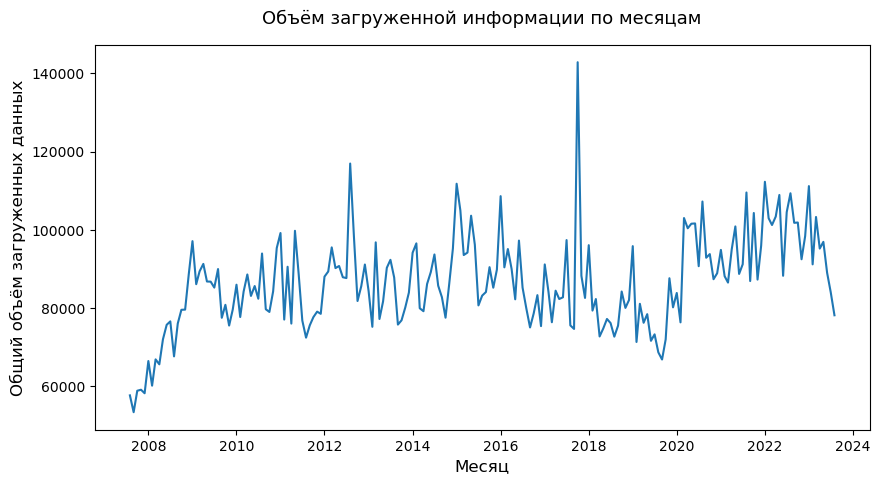

In [212]:
plt.figure(figsize=(10, 5))
volume_time = stats.pivot_table(index='report_month', values='volume_k', aggfunc=['sum'])
volume_time.reset_index(inplace=True)
volume_time.columns = ['month', 'volume']
print('Средний объём загружаемой информации в месяц', volume_time['volume'].mean())
sns.lineplot(x=volume_time['month'], y=volume_time['volume'])
plt.title('Объём загруженной информации по месяцам', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Месяц', fontsize=12, color='black')
plt.ylabel('Общий объём загруженных данных', fontsize=12, color='black')
plt.show()


Объём загружаемой информации спустя год после начала наблюдений также вышел на средний уровень (85572), который и удерживался всё время наблюдений, за исключением выбросов после 2012 года и перед 2018

**Вывод:**    
В течение двух лет после начала наблюдений количество правок вышло на средний уровень по датасету, около 166262, после чего наблюдался спад с 2012 года, сменившийся ростом в 2014, после которого значения вернулись к средним.
Объём загружаемой информации, спустя год после начала наблюдений, также вышел на средний уровень, около 85572, который и удерживался всё время наблюдений, за исключением выбросов после 2012 года и перед 2018

### Сегментация пользователей <a id='segments'></a>

Разделим пользователей на сегменты, взяв в качестве параметров время, прошедшее с последеней активности, частоту действий на платформе и количество правок, сначала выделим параметры из данных

In [213]:
now = stats['report_month'].max()

rfm_table=stats.groupby('user').agg({'volume_k': lambda x: x.sum(),
                                     'diff_k': lambda x: x.sum(),
                                     'time_h': lambda x: x.sum(),
                                     'report_month': [lambda x: x.count(), lambda x: (now - x.max()).days], # Recency
                                     'speed_h': lambda x: x.mean(), # Frequency
                                     'edits': lambda x: x.sum()})    # Monetary 

rfm_table.columns = ['volume', 'diff', 'hours_total', 'life_month', 'recency', 'frequency', 'monetary_value']
rfm_table.head()

,volume,diff,hours_total,life_month,recency,frequency,monetary_value
user,,,,,,,
-kgoodluck-,1555.0,1270.0,104.0,3,61,28.00,2801
0lesja Sh,139.0,120.0,35.0,1,4048,23.00,822
0x0F,66.0,48.0,43.0,1,2525,15.00,620
1.b2-b4,2101.0,16.0,369.0,4,2252,10.75,3998
102RB,425.0,379.0,40.0,1,4687,23.00,787


На следующем этапе определим границы сегментов, для чего будем использовать квартили

In [214]:
quantiles = rfm_table.quantile(q=[0.25,0.75])
quantiles

,volume,diff,hours_total,life_month,recency,frequency,monetary_value
0.25,351.0,178.0,55.0,1.0,852.0,16.0,916.0
0.75,4433.8,2389.0,548.0,10.0,4626.0,25.0,9206.0


Добавим в таблицу идентификаторы в соответствии с сегментами и сформируем столбец с классом пользователя

In [215]:
# Аргументы функций (x = value, p = recency, monetary_value, frequency, k = quartiles dict)

quantiles = quantiles.to_dict()

def r_class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 3

def fm_class(x,p,d):
    if x <= d[p][0.25]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
rfm_table['r_quartile'] = rfm_table['recency'].apply(r_class, args=('recency',quantiles,))
rfm_table['f_quartile'] = rfm_table['frequency'].apply(fm_class, args=('frequency',quantiles,))
rfm_table['m_quartile'] = rfm_table['monetary_value'].apply(fm_class, args=('monetary_value',quantiles,))
rfm_table['rfm_class'] = rfm_table.r_quartile.map(str) \
                            + rfm_table.f_quartile.map(str) \
                            + rfm_table.m_quartile.map(str)

**Группировка и оценка**    
Для каждого критерия выделим 3 группы. Каждой группе присвоим числовое обозначение от 1 до 3.

- Время, прошедшее с последеней активности `Recency`:    
  1 — недавние клиенты;    
  2 — относительно недавние клиенты;    
  3 — давние клиенты.    
  
    
- Частота действий на платформе `Frequency`:    
  1 — пользуются часто;    
  2 — пользуются нечасто;    
  3 — единичные действия.    
  
    
- Количество правок `Monetary`:    
  1 — большое количество правок;    
  2 — среднее количество правок;    
  3 — небольшое количество правок.

In [216]:
rfm_table.head()

,volume,diff,hours_total,life_month,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,rfm_class
user,,,,,,,,,,,
-kgoodluck-,1555.0,1270.0,104.0,3,61,28.00,2801,1,1,2,112
0lesja Sh,139.0,120.0,35.0,1,4048,23.00,822,2,2,3,223
0x0F,66.0,48.0,43.0,1,2525,15.00,620,2,3,3,233
1.b2-b4,2101.0,16.0,369.0,4,2252,10.75,3998,2,3,2,232
102RB,425.0,379.0,40.0,1,4687,23.00,787,3,2,3,323


Посмотрим как пользователи распределяются по классам

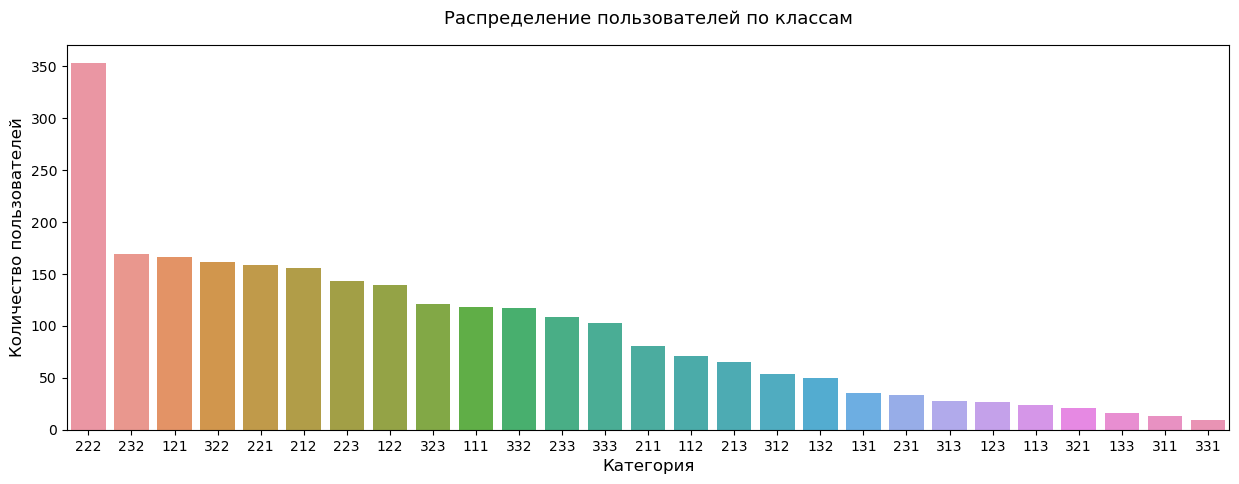

In [217]:
quantity = []
rfm = []
for element in rfm_table['rfm_class'].unique():
    quantity.append(int(len(rfm_table.loc[rfm_table['rfm_class'] == element ])))
    rfm.append(element)

df = pd.DataFrame([rfm, quantity])
df = df.T
df.columns = ['rfm', 'quantity']
df = df.sort_values(by='quantity', ascending=False)

plt.figure(figsize=(15, 5))
sns.barplot(x=df['rfm'], y=df['quantity'])
plt.title('Распределение пользователей по классам', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Категория', fontsize=12, color='black')
plt.ylabel('Количество пользователей', fontsize=12, color='black')
plt.show()

Самый большой сегмент представлен лояльными пользователями со средним уровнем активности. Большое число пользователей в сегменте потеряных и находящихся на грани оттока, связано с продолжительным периодом времени, охватывающим исследование. Меньше всего сегмент потерянных пользователей, внёсших большой вклад в платформу.

Посмотрим подробнее на пользователей в сегментах.

Лучшие пользователи

In [218]:
rfm_table[rfm_table['rfm_class']=='111'].sort_values('monetary_value', ascending=False).head(10)

,volume,diff,hours_total,life_month,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,rfm_class
user,,,,,,,,,,,
Simba16,67953.2,42685.554688,11423.000000,113,0,30.256637,346911,1,1,1,111
Q-bit array,340787.2,165044.600000,14034.000000,106,0,42.820755,289232,1,1,1,111
Игорь Темиров,200442.8,150171.900000,9341.000000,78,0,25.820513,221285,1,1,1,111
Fleur-de-farine,25744.0,16204.000000,5233.500000,78,0,39.346154,195991,1,1,1,111
Liilia Moroz,44316.8,17229.000000,6064.000000,68,0,30.102941,178789,1,1,1,111
AndreiK,35579.8,23640.000000,6639.000000,94,0,27.010638,169940,1,1,1,111
Mitte27,45674.8,14335.700000,7126.000000,106,0,33.801887,163362,1,1,1,111
GAndy,88711.4,20751.000000,7604.166667,81,61,32.691358,162320,1,1,1,111
Rartat,66079.6,62022.600000,5835.833333,115,0,30.582609,146840,1,1,1,111


Пользователи на пороге оттока

In [219]:
rfm_table[rfm_table['r_quartile'] > 2 ].sort_values('monetary_value', ascending=False).head(10)

,volume,diff,hours_total,life_month,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,rfm_class
user,,,,,,,,,,,
Ботильда,479.1,-241.528906,472.916667,12,4779,130.000000,62109,3,1,1,311
Четыре тильды,10329.0,7365.300000,1863.416667,28,4779,30.357143,58924,3,1,1,311
Maximaximax,6252.4,2328.000000,949.583333,14,4929,67.071429,29620,3,1,1,311
Павел Шехтман,14055.4,9635.000000,1902.000000,24,5052,15.583333,29098,3,3,1,331
Mitrius,20127.4,4382.200000,1646.000000,27,4748,19.962963,28853,3,2,1,321
Muscovite99,10202.0,4626.000000,1414.000000,22,4809,19.863636,28257,3,2,1,321
Ariely,14745.4,6133.000000,1646.000000,21,5174,18.952381,27502,3,2,1,321
Mariluna,6446.8,4495.000000,911.000000,13,5205,23.384615,23093,3,2,1,321
Сдобников Андрей,11848.0,8579.000000,1505.000000,25,4960,15.520000,22651,3,3,1,331


Потерянные пользователи

In [220]:
rfm_table[rfm_table['rfm_class']=='333'].sort_values('recency',ascending=False).head(10)

,volume,diff,hours_total,life_month,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,rfm_class
user,,,,,,,,,,,
DED,139.0,139.0,30.000000,1,5844,16.0,486,3,3,3,333
Asta~ruwiki,104.0,87.0,24.000000,1,5844,14.0,329,3,3,3,333
Виноградов П. Н.,133.0,133.0,28.000000,1,5844,15.0,418,3,3,3,333
Пиотровский Юрий,103.0,101.0,37.000000,1,5844,15.0,548,3,3,3,333
Nomad nomad,99.0,60.0,40.000000,1,5844,16.0,638,3,3,3,333
Deonix,281.0,170.0,40.000000,1,5844,16.0,622,3,3,3,333
Daniil naumoff,92.0,90.0,26.000000,1,5844,12.0,322,3,3,3,333
Иван Володин,302.0,211.0,26.000000,1,5844,15.0,372,3,3,3,333
Zhuravlik,87.0,83.0,23.333333,1,5844,16.0,331,3,3,3,333


Лояльные пользователи

In [221]:
rfm_table[rfm_table['rfm_class'] == '222' ].sort_values('monetary_value', ascending=False).head(10)

,volume,diff,hours_total,life_month,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,rfm_class
user,,,,,,,,,,,
Mithril,3777.0,1500.0,547.0,10,1156,18.300000,9194,2,2,2,222
Optimizm,11145.6,10133.8,613.5,17,883,21.470588,9074,2,2,2,222
Hdfan2,8998.8,6308.6,408.0,8,1034,23.375000,8853,2,2,2,222
Vlad2000Plus,17655.0,15208.0,438.0,8,1887,20.750000,8846,2,2,2,222
Странник27,2261.0,1473.0,505.0,8,4139,17.625000,8837,2,2,2,222
Dnikitin,5938.4,5584.4,629.0,11,4109,16.363636,8819,2,2,2,222
OLKOL63,4899.0,4846.0,561.0,9,2191,16.777778,8809,2,2,2,222
Scaut2002,11128.0,10856.0,661.0,9,973,18.666667,8655,2,2,2,222
Evacat,3350.0,2522.0,452.0,10,3379,21.100000,8628,2,2,2,222


Изучим распределение времени активности пользователей по сегментам

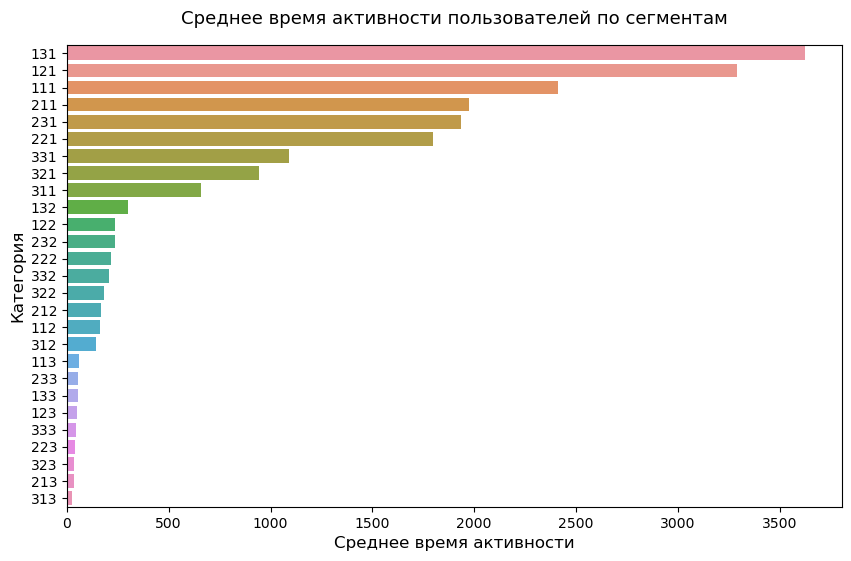

In [222]:
plt.figure(figsize=(10, 6))
rfm_liftime = rfm_table.pivot_table(index='rfm_class', values='hours_total', aggfunc=['mean'])
rfm_liftime.reset_index(inplace=True)
rfm_liftime.columns = ['rfm', 'hours_total']
rfm_liftime = rfm_liftime.sort_values(by='hours_total', ascending = False)
sns.barplot(y=rfm_liftime['rfm'], x=rfm_liftime['hours_total'])
plt.title('Среднее время активности пользователей по сегментам', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Среднее время активности', fontsize=12, color='black')
plt.ylabel('Категория', fontsize=12, color='black')
plt.show()

Большинство пользователей, долгое время находящихся на платформе сохраняют активность и на момент исследования, а замыкают группу лидеров по этому параметру пользователи, внёсшие значительный вклад в прошлом, но покинувшие платформу.

Посмотрим объём загруженных данных по сегментам

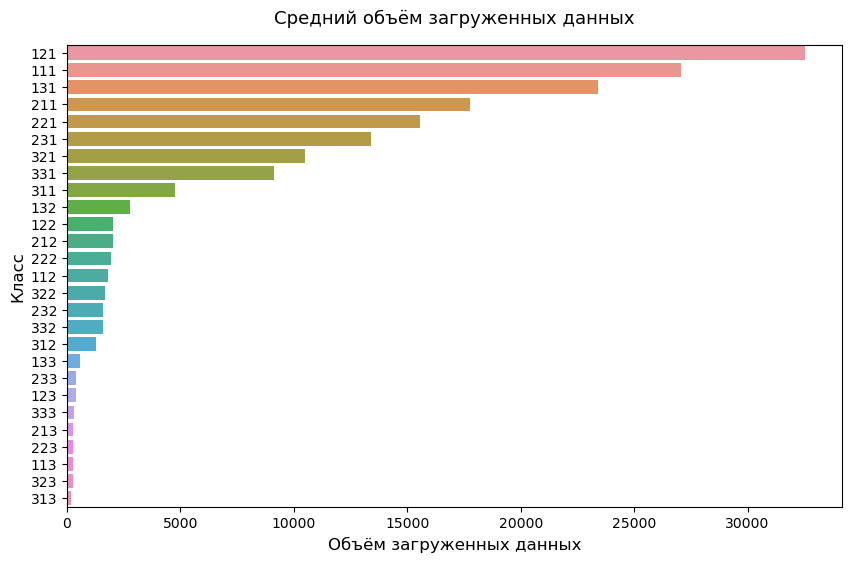

In [223]:
plt.figure(figsize=(10, 6))
rfm_liftime = rfm_table.pivot_table(index='rfm_class', values='volume', aggfunc=['mean'])
rfm_liftime.reset_index(inplace=True)
rfm_liftime.columns = ['rfm', 'volume']
rfm_liftime = rfm_liftime.sort_values(by='volume', ascending = False)
sns.barplot(y=rfm_liftime['rfm'], x=rfm_liftime['volume'])
plt.title('Средний объём загруженных данных', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Объём загруженных данных', fontsize=12, color='black')
plt.ylabel('Класс', fontsize=12, color='black')
plt.show()

Картина схожая - активные пользователи и обычные пользователи загружают наибольшее количество данных, а замыкают рейтинг лидеров потерянные пользователи, внёсшие когда-то значительный вклад

**Вывод:**    
Пользователи разделены на сегменты по времени, прошедшему с последеней активности, частоте действий на платформе и количеству правок. Для определения границ сегментов использовались квартили q1 и q3.
Самый большой сегмент представлен лояльными пользователями со средним уровнем активности. Большое число пользователей в сегменте потеряных и находящихся на грани оттока связано с продолжительным периодом времени, охватывающим исследование. Меньше всего сегмент потерянных пользователей, внёсших большой вклад в платформу.
Изучим распределение времени активности пользователей по сегментам
Большинство пользователей, долгое время находящихся на платформе сохраняют активность и на момент исследования, а замыкают группу лидеров по времени активности пользователи, внёсшие значительный вклад в прошлом, но покинувшие платформу.
Активные пользователи и лояльные пользователи загружают наибольшее количество данных, а замыкают рейтинг лидеров по загрузке данных - потерянные пользователи, внёсшие когда-то значительный вклад

### Вывод по разделу: <a id='conclusion2'></a>

Общее количество записей в таблице 28950. Данные получены за 193 месяца с 2007-08-01 по 2023-08-01, что является достаточной выборкой для проведения исследования. В данных присутствуют записи с подозрительно большой активностью (более 60 действий в минуту), похоже что это боты, которые за считанные часы совершили тысячи действий, но в выборке такие случаи носят единичный характер, не внося искажение в общую статистику, что свидетельствует о хороше защите платформы.
Средний объём загружаемых пользователем данных составляет 473 килобайта. Чаще всего пользователи загружают около 250 килобайт, но не вся информация остаётся, с учетом удалений данных, в среднем итоговый объём составляет 292 килобайта вместо 473, что свидетельствует как о качественном отборе информации, так и надёжных изначальных данных.
Обычно пользователи проводят на платформе от 40 до 70 часов и совершают около 20 действий в час. Зависимость объёма добавленной инормации от времени, проведённого на платформе незначительная, коэффициент корреляции равен 0.4. Основная часть пользователей проводит на платформе не более 200 часов и добавляют не более 2 мегабайт данных.

В течение двух лет после начала наблюдений количество правок вышло на средний уровень по датасету, около 166262, после чего наблюдался спад с 2012 года, сменившийся ростом в 2014, после которого значения вернулись к средним.
Объём загружаемой информации, спустя год после начала наблюдений, также вышел на средний уровень, около 85572, который и удерживался всё время наблюдений, за исключением выбросов после 2012 года и перед 2018

Пользователи разделены на сегменты по времени, прошедшему с последеней активности, частоте действий на платформе и количеству правок. Для определения границ сегментов использовались квартили q1 и q3. Самый большой сегмент представлен лояльными пользователями со средним уровнем активности. Большое число пользователей в сегменте потеряных и находящихся на грани оттока связано с продолжительным периодом времени, охватывающим исследование. Меньше всего сегмент потерянных пользователей, внёсших большой вклад в платформу. Изучим распределение времени активности пользователей по сегментам Большинство пользователей, долгое время находящихся на платформе сохраняют активность и на момент исследования, а замыкают группу лидеров по времени активности пользователи, внёсшие значительный вклад в прошлом, но покинувшие платформу. Активные пользователи и лояльные пользователи загружают наибольшее количество данных, а замыкают рейтинг лидеров по загрузке данных - потерянные пользователи, внёсшие когда-то значительный вклад

## Агрегация данных <a id='agregation'></a>

Объединим таблицы чтобы посмотреть есть ли зависимость отданных голосов от характеристик пользователей

In [224]:
vote_to_rfm = rfm_table.join(votes.pivot_table(index='voter',
                                                 values=['vote', 'candidate'], aggfunc='count')).fillna(0)
print('Количество пользователей составляет', len(vote_to_rfm))
vote_to_rfm.head()

Количество пользователей составляет 2541


,volume,diff,hours_total,life_month,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,rfm_class,candidate,vote
user,,,,,,,,,,,,,
-kgoodluck-,1555.0,1270.0,104.0,3,61,28.00,2801,1,1,2,112,0.0,0.0
0lesja Sh,139.0,120.0,35.0,1,4048,23.00,822,2,2,3,223,0.0,0.0
0x0F,66.0,48.0,43.0,1,2525,15.00,620,2,3,3,233,0.0,0.0
1.b2-b4,2101.0,16.0,369.0,4,2252,10.75,3998,2,3,2,232,15.0,15.0
102RB,425.0,379.0,40.0,1,4687,23.00,787,3,2,3,323,0.0,0.0


Объединение прошло без ошибок, теперь узнаем есть ли зависимость количества голосов от объёма внесенных данных

### Параметры голосующих пользователей <a id='rfm_votes'></a>

Коэффициент корреляции количества голосов и объёма добавленных данных: 0.36083465739688814


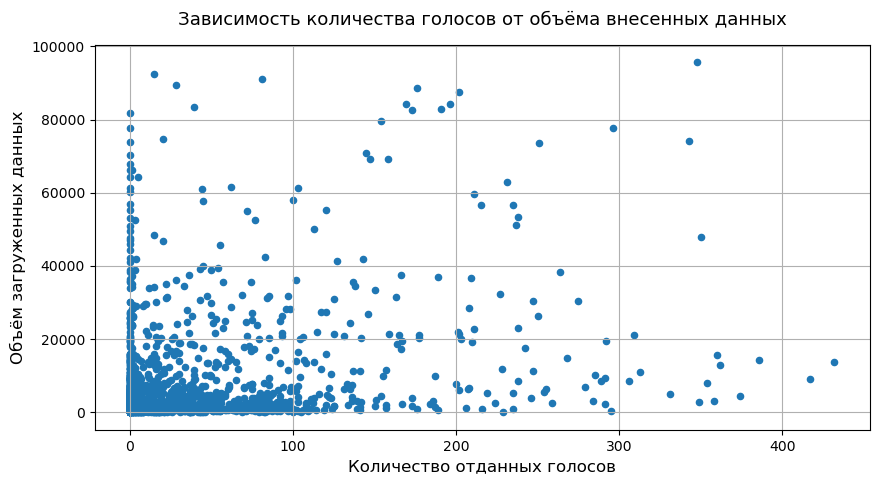

In [225]:
clean_vote_to_rfm = vote_to_rfm.query('volume < 100000')
print('Коэффициент корреляции количества голосов и объёма добавленных данных:', \
      clean_vote_to_rfm['volume'].corr(clean_vote_to_rfm['vote']))
clean_vote_to_rfm.plot(y='volume', x='vote', kind='scatter', \
        figsize=(10, 5), sharex=False, grid=True)
plt.title('Зависимость количества голосов от объёма внесенных данных', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Количество отданных голосов', fontsize=12, color='black')
plt.ylabel('Объём загруженных данных', fontsize=12, color='black')
plt.show()

Прямая зависимость отсутствует, часто пользователи с больши объёмом загруженной информации вообще не участвуют в голосовании.

Рассмотрим активность на голосовании по сегментам

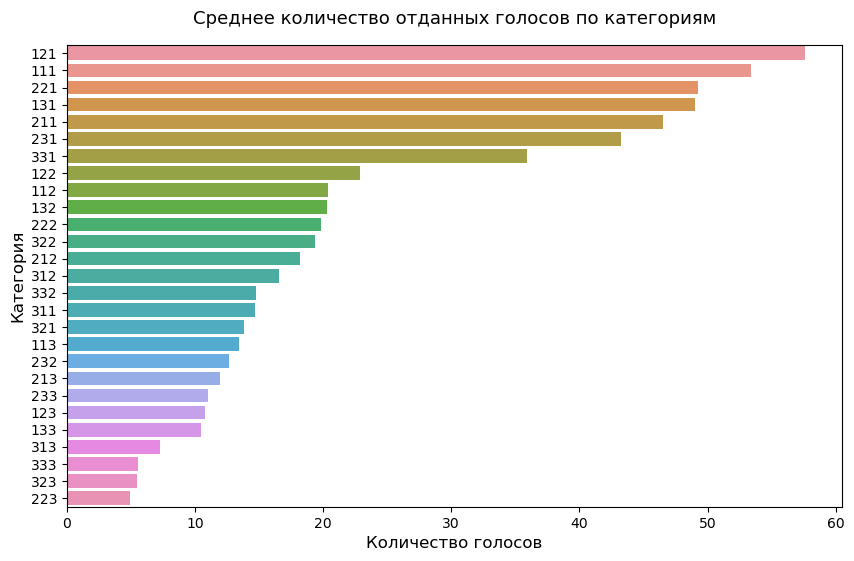

In [226]:
plt.figure(figsize=(10, 6))
vote_to_rfm_plot = vote_to_rfm.pivot_table(index='rfm_class', values='vote', aggfunc='mean')
vote_to_rfm_plot.reset_index(inplace=True)
vote_to_rfm_plot = vote_to_rfm_plot.sort_values(by='vote', ascending=False) 
sns.barplot(y=vote_to_rfm_plot['rfm_class'], x=vote_to_rfm_plot['vote'], errorbar=None)
plt.title('Среднее количество отданных голосов по категориям', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Количество голосов', fontsize=12, color='black')
plt.ylabel('Категория', fontsize=12, color='black')
plt.show()

График показывает, что пользователи вносящие большое количество правок голосуют активнее других.

**Вывод:**    
Объединение прошло без ошибок. Количество голосов от объёма внесенных данных зависит слабо (коэффициет корреляции равен 0.36), часто пользователи с больши объёмом загруженной информации вообще не участвуют в голосовании.
Активность на голосовании по сегментам показывает, что пользователи вносящие большое количество правок, голосуют активнее других.

### Параметры кандидатов <a id='rfm_candidates'></a>

Далее посмотрим распределение кандидатов по сегментам

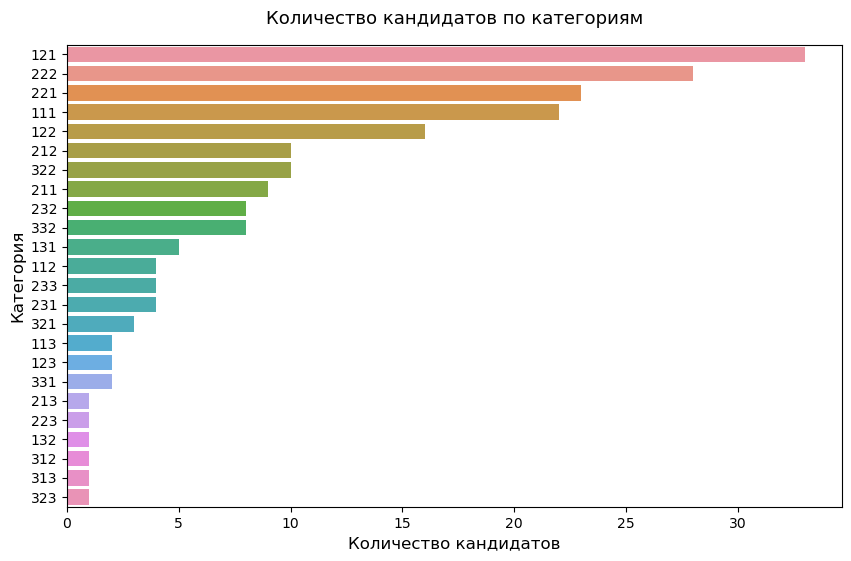

In [227]:
plt.figure(figsize=(10, 6))
candidates_result = votes.groupby('candidate').agg({'vote' : ['count', 'sum']})
candidates_result.columns = ['count', 'sum']
candidates_result['result'] = candidates_result['sum'] / candidates_result['count']
candidates_result.reset_index(inplace=True)
candidates_result.columns = ['candidate', 'count', 'sum', 'result']

candidate_to_rfm = vote_to_rfm.query('user in @candidates_result.candidate')

candidate_to_rfm_plot = candidate_to_rfm.pivot_table(index='rfm_class', values='candidate', aggfunc='count')
candidate_to_rfm_plot.reset_index(inplace=True)
candidate_to_rfm_plot = candidate_to_rfm_plot.sort_values(by='candidate', ascending=False) 
sns.barplot(y=candidate_to_rfm_plot['rfm_class'], x=candidate_to_rfm_plot['candidate'], errorbar=None)
plt.title('Количество кандидатов по категориям', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Количество кандидатов', fontsize=12, color='black')
plt.ylabel('Категория', fontsize=12, color='black')
plt.show()

Чаще становятся кандидатами пользователи из сегмента вносящего большой и средний вклад в развитие платформы, и при этом обладающие средней и высокой лояльностью.

Рассмотрим какие параметры кандидата влияют на результат выборов, для этого объединим таблицы с результатами голосования и сегментами

In [228]:
candidates_result.columns = ['user', 'count', 'sum', 'result']
result_to_rfm = candidate_to_rfm.merge(candidates_result, on='user', how='left').fillna(0)
result_to_rfm.head()

,user,volume,diff,hours_total,life_month,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,rfm_class,candidate,vote,count,sum,result
0,A.Vajrapani,820.0,395.0,104.0,2,3925,25.000000,2294,2,2,2,222,176.0,176.0,1339,405,0.302465
1,Abiyoyo,79551.2,8458.2,5653.0,72,31,29.250000,117343,1,1,1,111,154.0,154.0,580,94,0.162069
2,Adamant.pwn,2515.0,1689.0,275.0,6,1126,17.166667,4146,2,2,2,222,56.0,56.0,660,188,0.284848
3,Agent001,4320.8,1033.0,368.0,7,4991,14.000000,4989,3,3,2,332,35.0,35.0,127,-101,-0.795276
4,Ailbeve,2815.0,1504.0,247.0,4,1126,16.000000,3291,2,3,2,232,90.0,90.0,253,-73,-0.288538




Посмотрим параметры кандидата, влияющие на результат, начнём с количества правок

Коэффициент корреляции результата выборов и количества правок: 0.13641861940947453


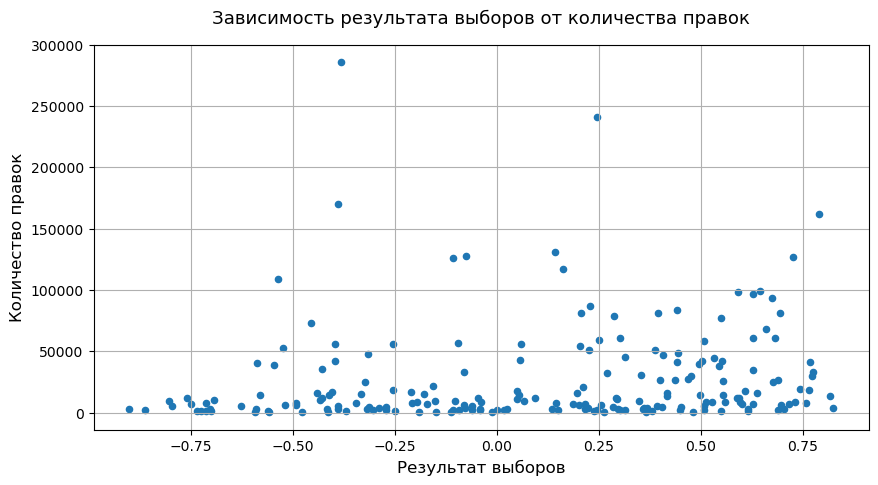

In [229]:
print('Коэффициент корреляции результата выборов и количества правок:', \
      result_to_rfm['monetary_value'].corr(result_to_rfm['result']))
result_to_rfm.plot(y='monetary_value', x='result', kind='scatter', \
       figsize=(10, 5), sharex=False, grid=True)
plt.title('Зависимость результата выборов от количества правок', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Результат выборов', fontsize=12, color='black')
plt.ylabel('Количество правок', fontsize=12, color='black')
plt.show()

Корреляция очень слабая, посмотрим, может быть объём внесённых данных больше влияет на победу

Коэффициент корреляции результата выборов и загруженных данных: 0.29972783919876156


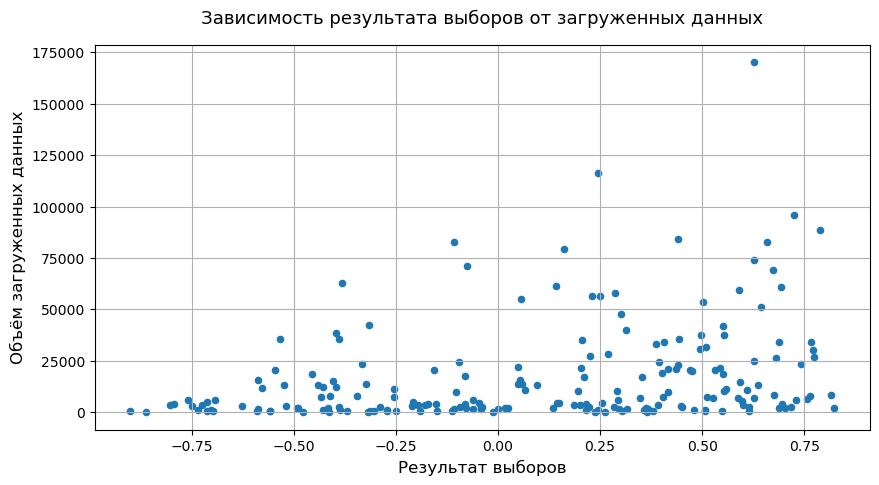

In [230]:
print('Коэффициент корреляции результата выборов и загруженных данных:', \
      result_to_rfm['volume'].corr(result_to_rfm['result']))
result_to_rfm.plot(y='volume', x='result', kind='scatter', \
        title='Зависимость результата выборов от загруженных данных', figsize=(10, 5), sharex=False, grid=True)
plt.title('Зависимость результата выборов от загруженных данных', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Результат выборов', fontsize=12, color='black')
plt.ylabel('Объём загруженных данных', fontsize=12, color='black')
plt.show()

Взаимосвязь уже лучше прослеживается, но всёже ещё слабая - коэффициент 0.3. Проверим, как влияет на результат выборов время проведённое на платформе

Коэффициент корреляции результата выборов и проведённого на платформе времени: 0.21632728575235335


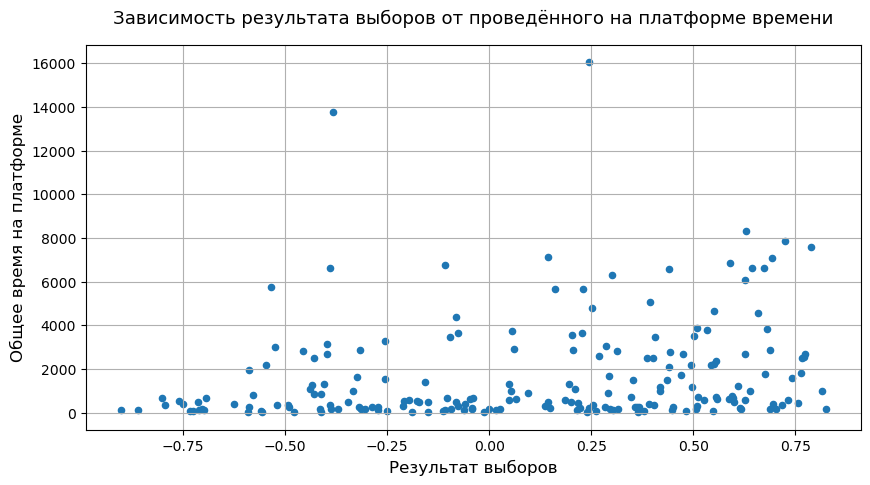

In [231]:
print('Коэффициент корреляции результата выборов и проведённого на платформе времени:', \
      result_to_rfm['hours_total'].corr(result_to_rfm['result']))
result_to_rfm.plot(y='hours_total', x='result', kind='scatter', \
        title='Зависимость результата выборов от проведённого на платформе времени', figsize=(10, 5), sharex=False, grid=True)
plt.title('Зависимость результата выборов от проведённого на платформе времени', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Результат выборов', fontsize=12, color='black')
plt.ylabel('Общее время на платформе', fontsize=12, color='black')
plt.show()

Большое количество времени, проведённое на платформе, также не даёт гарантии победы на выборах, коэффициент корреляции 0.2.

Рассмотрим какие результаты получают кандидаты в зависимости от сегмента

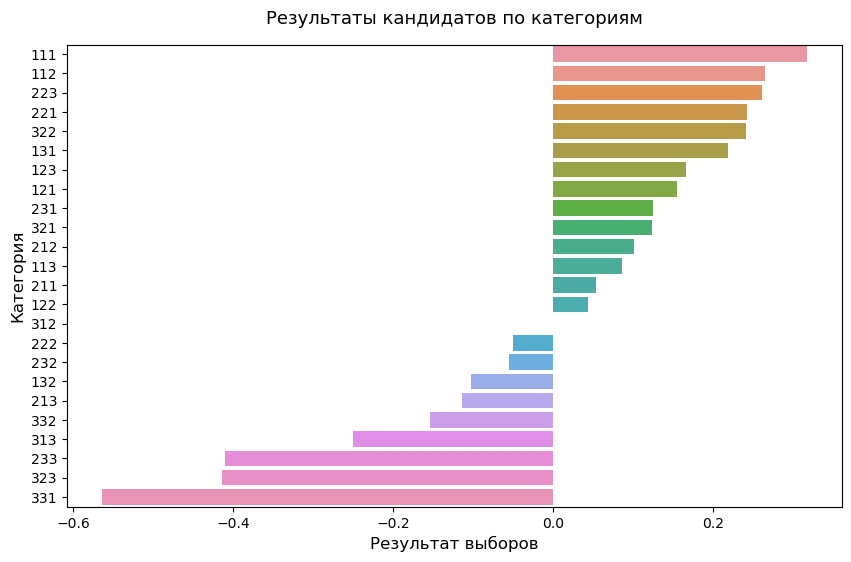

In [232]:
plt.figure(figsize=(10, 6))
result_to_rfm_plot = result_to_rfm.pivot_table(index='rfm_class', values='result', aggfunc='mean')
result_to_rfm_plot.reset_index(inplace=True)
result_to_rfm_plot.sort_values(by='result', ascending=False)
result_to_rfm_plot = result_to_rfm_plot.sort_values(by='result', ascending=False)

sns.barplot(y=result_to_rfm_plot['rfm_class'], x=result_to_rfm_plot['result'], errorbar=None)
plt.title('Результаты кандидатов по категориям', loc ='center', pad = 15, fontsize=13, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Результат выборов', fontsize=12, color='black')
plt.ylabel('Категория', fontsize=12, color='black')
plt.show()

Кандидаты с высокой лояльностью и большим вкладом получают больший средний результат, а пользователи с низкой активностью чаще получают отрицательный результат.

**Вывод:**    
Чаще становятся кандидатами пользователи из сегмента вносящего большой и средний вклад в развитие платформы, и при этом обладающие средней и высокой лояльностью.
Количество правок, сделанное кандидатом не влияет на результат выборов, коэффициент корреляции равен 0.13.
Поведённое платформе время чуть больше влияет на результат, коэффициент корреляции 0.21, но всё же это влияние незначительно.
Коэффициент корреляции результата выборов и загруженных данных составляет 0.3, взаимосвязь прослеживается уже лучше, но это очень слабая зависимость, большое количество загруженных данных не даёт гарантии победы на выборах.
Средний результат по сегментам показывает, что кандидаты с высокой лояльностью и большим вкладом лучше проявляют себя на выборах, а пользователи с низкой активностью чаще получают отрицательный результат.

### Вывод по разделу: <a id='conclusion_3'></a>

Объединение данных пользователей и данных по голосованиям прошло без ошибок, итоговая таблица включает 2541 запись.    
Анализ агрегированных данных показал, что количество голосов от объёма внесенных данных зависит слабо (коэффициет корреляции равен 0.36), часто пользователи с больши объёмом загруженной информации вообще не участвуют в голосовании.
Активность на голосовании по сегментам показывает, что пользователи вносящие большое количество правок, голосуют активнее других.

Чаще становятся кандидатами пользователи из сегмента вносящего большой и средний вклад в развитие платформы, и при этом обладающие средней и высокой лояльностью. Количество правок, сделанное кандидатом не влияет на результат выборов, коэффициент корреляции равен 0.13. Поведённое платформе время чуть больше влияет на результат, коэффициент корреляции 0.21, но всё же это влияние незначительно. Коэффициент корреляции результата выборов и загруженных данных составляет 0.3, взаимосвязь прослеживается уже лучше, но это очень слабая зависимость, большое количество загруженных данных не даёт гарантии победы на выборах. Средний результат по сегментам показывает, что кандидаты с высокой лояльностью и большим вкладом лучше проявляют себя на выборах, а пользователи с низкой активностью чаще получают отрицательный результат.

## Результаты исследования <a id='result'></a>

**Исследование данных о выборах**    
- Загрузка данных о выборах для первого этапа исследования без ошибок, после приведения данных в столбце `time` к формату datetime, все данные сохранились в нужном формате, пропуски и дубликаты отсутствуют. Итоговая таблица содержит 79074 записей, что является достаточной выборкой для проведения исследования.    
- В данных содержалась информация о 44 проведенных выборах за почти 15 лет с 2008-11-23 до 2023-08-30. Наибольшая активность голосования наблюдалась в день начала выборов, в этот день отдавалась половина голосов, но, несмотря на всплеск в начале голосования, среднее и медианное значение распределения не совпали из-за сохранения активности пользователей в последующие дни. Чаще пользователи голосовали в поддержку кандидатов, но голосов противников набиралось 40%. Обычно кандидат принимал участие в одних или двух выборах, но встречались кандидаты с большим количеством участий, вплоть до 14.
- Расчитали количество сторонников, противников кандидатов и результаты выборов. В подсчёте результатов учитывались только голоса пользователей, подходящих по параметрам. Распределение сторонников и противников для кандидатов из топ-10 по результатам выборов показывает, что порой получают лучший результат не те кандидаты, у кого больше сторонников, а те, у кого меньше противников. Дважды в топ-10 не удалось попасть никому из кандидатов. Чаще всего кандидаты не преодолевают порог поддержки 50%, медианное значение по выборам 0.44, а среднее значение результата близко к нулю и составляет 0.13, из-за большого количества отрицательных результатов у кандидатов.    
- Близкий к итоговому результат голосования определяются уже в первый день, в дальнейшие дни результат меняется незначительно

**Исследование данных о пользователях**  
- Общее количество записей в таблице stats составляет 28950. Данные получены за 193 месяца с 2007-08-01 по 2023-08-01, что является достаточной выборкой для проведения исследования. В данных присутствуют записи с подозрительно большой активностью (более 60 действий в минуту), похоже что это боты, которые за считанные часы совершили тысячи действий, но в выборке такие случаи носят единичный характер, не внося искажение в общую статистику, что свидетельствует о хороше защите платформы.
- Средний объём загружаемых пользователем данных составляет 473 килобайта. Чаще всего пользователи загружают около 250 килобайт, но не вся информация остаётся, с учетом удалений данных, в среднем итоговый объём составляет 292 килобайта вместо 473, что свидетельствует как о качественном отборе информации, так и надёжных изначальных данных. Обычно пользователи проводят на платформе от 40 до 70 часов и совершают около 20 действий в час. Зависимость объёма добавленной инормации от времени, проведённого на платформе незначительная, коэффициент корреляции равен 0.4. Основная часть пользователей проводит на платформе не более 200 часов и добавляют не более 2 мегабайт данных.
- В течение двух лет после начала наблюдений количество правок вышло на средний уровень по датасету, около 166262, после чего наблюдался спад с 2012 года, сменившийся ростом в 2014, после которого значения вернулись к средним. Объём загружаемой информации, спустя год после начала наблюдений, также вышел на средний уровень, около 85572, который и удерживался всё время наблюдений, за исключением выбросов после 2012 года и перед 2018
- Пользователи разделены на сегменты по времени, прошедшему с последеней активности, частоте действий на платформе и количеству правок. Для определения границ сегментов использовались квартили q1 и q3. Самый большой сегмент представлен лояльными пользователями со средним уровнем активности. Большое число пользователей в сегменте потеряных и находящихся на грани оттока связано с продолжительным периодом времени, охватывающим исследование. Меньше всего сегмент потерянных пользователей, внёсших большой вклад в платформу. Изучим распределение времени активности пользователей по сегментам Большинство пользователей, долгое время находящихся на платформе сохраняют активность и на момент исследования, а замыкают группу лидеров по времени активности пользователи, внёсшие значительный вклад в прошлом, но покинувшие платформу. Активные пользователи и лояльные пользователи загружают наибольшее количество данных, а замыкают рейтинг лидеров по загрузке данных - потерянные пользователи, внёсшие когда-то значительный вклад


**Исследование агрегированных данных**  
- Объединение данных пользователей и данных по голосованиям прошло без ошибок, итоговая таблица включает 2541 запись. Анализ агрегированных данных показал, что количество голосов от объёма внесенных данных зависит слабо (коэффициет корреляции равен 0.36), часто пользователи с больши объёмом загруженной информации вообще не участвуют в голосовании. Активность на голосовании по сегментам показывает, что пользователи вносящие большое количество правок, голосуют активнее других.
- Чаще становятся кандидатами пользователи из сегмента вносящего большой и средний вклад в развитие платформы, и при этом обладающие средней и высокой лояльностью. Количество правок, сделанное кандидатом не влияет на результат выборов, коэффициент корреляции равен 0.13. Поведённое платформе время чуть больше влияет на результат, коэффициент корреляции 0.21, но всё же это влияние незначительно. Коэффициент корреляции результата выборов и загруженных данных составляет 0.3, взаимосвязь прослеживается уже лучше, но это очень слабая зависимость, большое количество загруженных данных не даёт гарантии победы на выборах. Средний результат по сегментам показывает, что кандидаты с высокой лояльностью и большим вкладом лучше проявляют себя на выборах, а пользователи с низкой активностью чаще получают отрицательный результат.

**Вывод:**    
Обычные пользователи Википедии проявляют среднюю активность в редактировании и внесении данных, но из-за их большого количества, многие из них становятся кандидатами на выборах, но результаты их в среденем отрицательные. Чаще побеждают кандидаты, внёсшие вклад в платформу выше среднего, но даже для них нет единого параметра, который являлся бы фактором победы, скорее на результат влияет сбалансированный суммарный вклад в платформу в части редактирования, загрузки информации и суммарного времени на платформе.